# DEEP LEARNING

# Objective: Deblurring of Images  
## Using One <i><b>Deep Learning and</i> one <i><b>Non-Deep Learning Model
## Optimizing using <i><b>ONNX Runtime</i> and benchmark the solution
## Serving the Model

## <i>Importing libraries

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

### Loading the directores and taking only images with 'jpg','png','jpeg' and load images to a list

In [15]:
import os
from tqdm import tqdm
from keras.preprocessing import image

# Directory containing the images
directory = '/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp'

# Get a list of all files in the directory
files = os.listdir(directory)

# Filter out only the image files
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]

# Load each image file
all_images = []
for filename in tqdm(image_files):
    # Construct the full path to the image file
    filepath = os.path.join(directory, filename)
    # Load the image
    img = image.load_img(filepath, target_size=(80, 80, 3))
    img = image.img_to_array(img)
    img = img / 255.0
    all_images.append(img)

100%|██████████| 100/100 [00:05<00:00, 19.11it/s]


## Converting the images to np Arrays 

### For better processing as large amount of images are not efficiently processd they are converted to numPy arrays

In [18]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.3)

## Image Pixelation Funtion

* Purpose:  Reduce the resolution of images while keeping their size constant


In [19]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA) #cv2.resize the image to a smaller size
                                                                               #INTER_AREA averages the pixels
  return low_res_image

## Apply Pixelation to training and validation sets

* Purpose: Create low resolution version of the training and validation images

In [21]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)

# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

## Define the Autoencoder Model

* Purpose: Define the architecture of the autoencoder for image resconstruction .
* Includes Encodeing and Decoding

In [22]:

Input_img = Input(shape=(80, 80, 3))  

#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse') #mse funtion measures avg squared diff b/w the reconsturcted img and original input

### Callbacks 

* Used Eaarly stopping to prevent overitting and reduce learning rate on plateau

In [23]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

## Data Augmentation 

* Apply random transformation to training images 

In [24]:
datagen = ImageDataGenerator(
           rotation_range = 10,
           width_shift_range = 0.1,
           height_shift_range = 0.1,
           horizontal_flip = True
)
datagen.fit(train_x_px)

In [25]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 80, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 80, 80, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 80, 80, 3)      │         6,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,867 (3.01 MB)

 Trainable params: 788,867 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
a_e = autoencoder.fit(train_x_px, train_x,
            epochs=100,
            batch_size=16,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks= [early_stopper,reduce_lr] 
                     )

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0085 - val_loss: 0.0088 - learning_rate: 1.5625e-05
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0085 - val_loss: 0.0088 - learning_rate: 1.5625e-05
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0085 - val_loss: 0.0088 - learning_rate: 1.5625e-05
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0085 - val_loss: 0.0088 - learning_rate: 1.5625e-05
Epoch 4: early stopping


## Train the encoder model 

* <b>Saving the model

In [116]:
autoencoder.save('autoencoder.h5')

**Display predictions**

In [117]:
predictions = autoencoder.predict(val_x_px)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


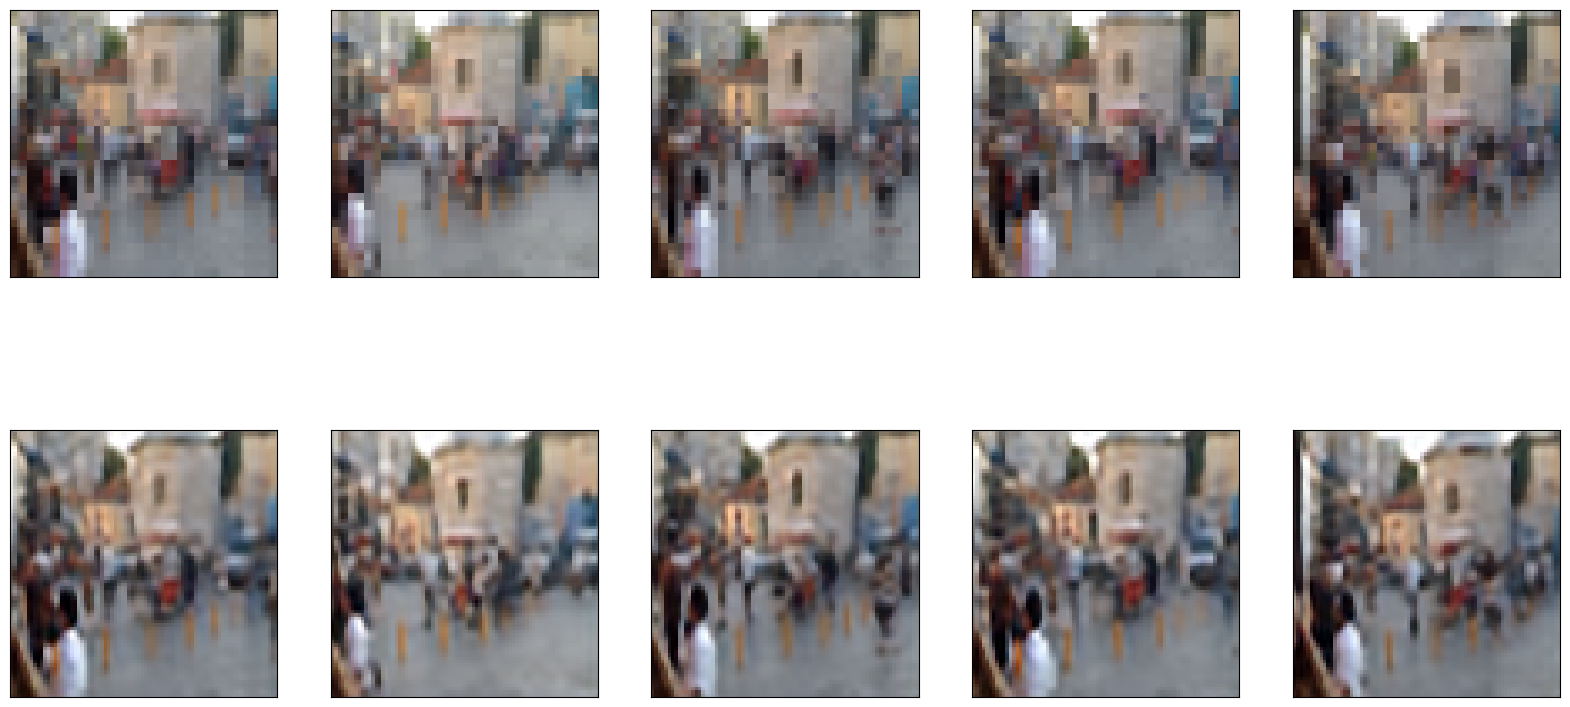

In [118]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

NON DEEP-LEARNING

### Loading and displaying the images Original images

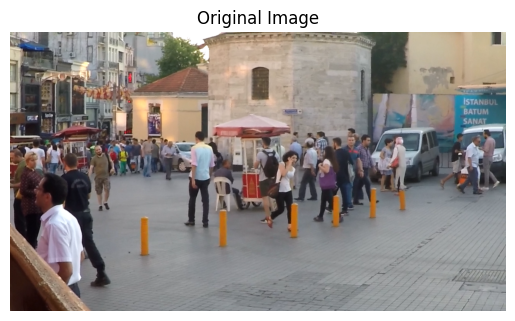

In [1]:
from skimage import io
import matplotlib.pyplot as plt

# Load the original image
original_image = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png')
# /kaggle/input/gopro-large/GOPRO_Large/train/GOPR0380_11_00/sharp/000140.png
# Display the original image
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

### Motion Blur

* Create a motion blur effect using a point Spread function(PSF)
* Displlaying the blurred image

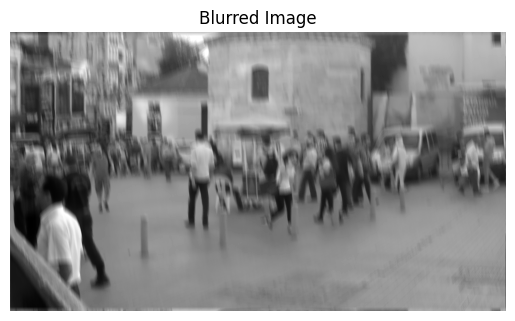

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from scipy.ndimage import convolve

# Create a motion blur Point Spread Function (PSF)
def motion_blur_psf(length, angle):
    size = length
    psf = np.zeros((size, size))
    center = size // 2
    slope = np.tan(np.deg2rad(angle))
    for i in range(size):
        offset = int(center + (i - center) * slope)
        if 0 <= offset < size:
            psf[i, offset] = 1
    psf /= psf.sum()
    return psf

# Load the original image
original_image = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png', as_gray=True)  # Replace with the actual file path
original_image = img_as_float(original_image)  # Convert to double precision

# Create motion blur PSF
psf = motion_blur_psf(21, 11)

# Apply the motion blur PSF to the image using convolution
blurred_image = convolve(original_image, psf, mode='wrap')

# Display the blurred image
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.show()

## Image resolution with  WIENER DECONVOLUTION

* Purpose: Restore the blurred image using this non-deep learning Model
* Displaying both the images side by side

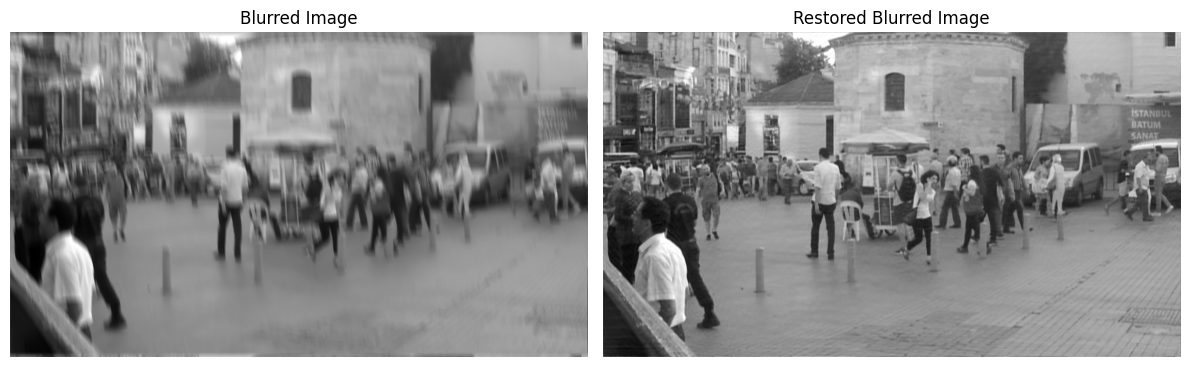

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, restoration, img_as_float
from scipy.ndimage import convolve


# Load the original image
original_image = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png', as_gray=True)  # Replace with the actual file path
original_image = img_as_float(original_image)  # Convert to double precision

# Create motion blur PSF
psf = motion_blur_psf(21, 11)

# Apply the motion blur PSF to the image using convolution
blurred_image = convolve(original_image, psf, mode='wrap')

# Apply Wiener deconvolution to the blurred image
restored_image = restoration.wiener(blurred_image, psf, balance=0.01)

# Display the blurred image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

# Display the restored image
plt.subplot(1, 2, 2)
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Blurred Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Add Gaussian Noise and Restore

* Purpose: Simulate real-world scenarios by adding Gaussian noise to the blurred image
1. Define the Gaussian noise parameters
2. Add Gaussian noise to the blurred image.
3. Display the noisy image

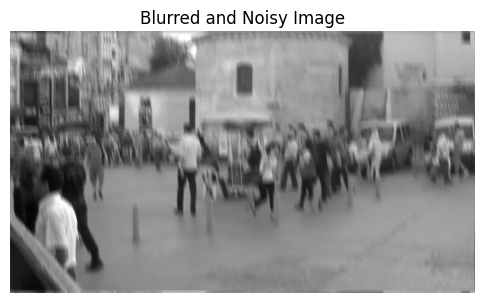

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, restoration, img_as_float
from skimage.util import random_noise
from scipy.ndimage import convolve

# Load the original image
original_image = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png', as_gray=True)  # Replace with the actual file path
original_image = img_as_float(original_image)  # Convert to double precision

# Create motion blur PSF
psf = motion_blur_psf(21, 11)

# Apply the motion blur PSF to the image using convolution
blurred_image = convolve(original_image, psf, mode='wrap')

# Define Gaussian noise parameters
noise_mean = 0
noise_var = 0.0001

# Add Gaussian noise to the blurred image
blurred_noisy_image = random_noise(blurred_image, mode='gaussian', mean=noise_mean, var=noise_var)

# Display the blurred and noisy image
plt.figure(figsize=(6, 6))
plt.imshow(blurred_noisy_image, cmap='gray')
plt.title('Blurred and Noisy Image')
plt.axis('off')
plt.show()

### Image Quantization

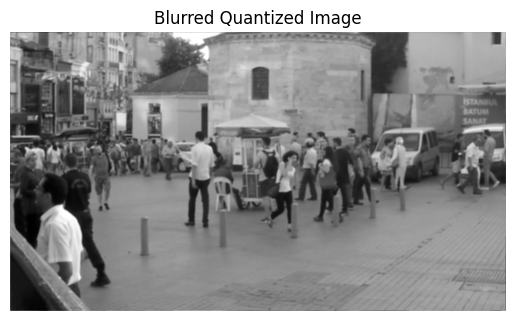

In [8]:
from skimage import io
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
Ioriginal = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png')

# Convert the original image to grayscale if it's not already
if len(Ioriginal.shape) > 2:
    Ioriginal = np.mean(Ioriginal, axis=2)

# Define the Point Spread Function (PSF)
PSF = np.ones((5, 5)) / 25  # Example PSF with size 5x5

# Perform convolution with circular boundary conditions
blurred_quantized = convolve2d(Ioriginal, PSF, mode='same', boundary='wrap')

# Display the blurred quantized image
plt.imshow(blurred_quantized, cmap='gray')
plt.title('Blurred Quantized Image')
plt.axis('off')
plt.show()

## Wiener Deconvolution on Quantized Image

* Purpose: Restore the quantized blurred image using Wiener deconvolution .

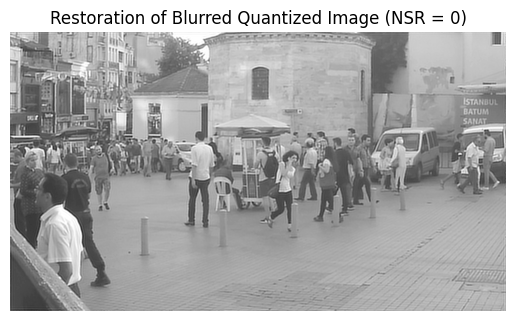

In [9]:
from skimage import restoration, io
import matplotlib.pyplot as plt

# Load the blurred quantized image
blurred_quantized = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png', as_gray=True)

# Define the Point Spread Function (PSF)
PSF = np.ones((5, 5)) / 25  # Example PSF with size 5x5

noise_var = 0.1
# Perform Wiener deconvolution
wnr4 = restoration.wiener(blurred_quantized, PSF, noise_var)

# Display the restored image
plt.imshow(wnr4, cmap='gray')
plt.title('Restoration of Blurred Quantized Image (NSR = 0)')
plt.axis('off')
plt.show()

## Wiener Deconvolution with Estimated NSR
* Purpose: Estimate NSR ratio and use it for wiener deconvolution.

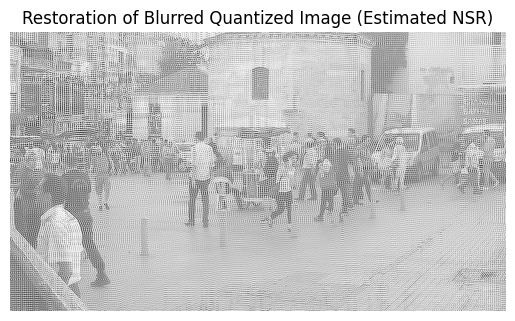

In [10]:
from skimage import restoration, io
import numpy as np
import matplotlib.pyplot as plt

# Load the blurred quantized image
blurred_quantized = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png', as_gray=True)

# Define the Point Spread Function (PSF)
PSF = np.ones((5, 5)) / 25  # Example PSF with size 5x5

# Uniform quantization variance
uniform_quantization_var = (1 / 256) ** 2 / 12

# Calculate signal variance
signal_var = np.var(blurred_quantized.flatten())

# Calculate Noise-to-Signal Ratio (NSR)
NSR = uniform_quantization_var / signal_var

# Perform Wiener deconvolution with estimated NSR
wnr5 = restoration.wiener(blurred_quantized, PSF, NSR)

# Display the restored image
plt.imshow(wnr5, cmap='gray')
plt.title('Restoration of Blurred Quantized Image (Estimated NSR)')
plt.axis('off')
plt.show()

### Convert Keras Model to ONNX

In [11]:
!pip install tf2onnx onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 3.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


### converting a TensorFlow autoencoder model to ONNX format and benchmarking its performance using ONNX Runtime.

### Importing libraries and Defining custom Loss Function

* It also defines a custom Mean Squared Error(MSE) loss function to be used later when loading the 

In [13]:
import tensorflow as tf
import onnxruntime as ort
import numpy as np
import time
import os
from tqdm import tqdm
from keras.preprocessing import image
import tf2onnx
# Define custom loss function
def mse(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

### Loading and Converting the Autoencoder Model

* The loaded Keras model is then converted to ONNX format and saved in onnx format

In [119]:
# Load the autoencoder model with the custom loss function
custom_objects = {'mse': mse}
autoencoder_model = tf.keras.models.load_model('autoencoder.h5', custom_objects=custom_objects)

# Convert the Autoencoder Model to ONNX
input_shape = (1, 80, 80, 3)
spec = (tf.TensorSpec(input_shape, tf.float32, name="input"),)
onnx_model_path = "autoencoder.onnx"
model_proto, _ = tf2onnx.convert.from_keras(autoencoder_model, input_signature=spec, output_path=onnx_model_path)
print(f"ONNX model saved to {onnx_model_path}")

ONNX model saved to autoencoder.onnx


## Benchmarking the ONNX Model

* Benchmarked to measure the average inference latency over a number of runs

In [120]:
# Benchmark the ONNX Model using ONNX Runtime
session = ort.InferenceSession(onnx_model_path)

# Benchmarking function
def benchmark_onnx_model(session, input_data, num_runs=100):
    latencies = []
    for _ in range(num_runs):
        start_time = time.time()
        session.run(None, {"input": input_data})
        end_time = time.time()
        latencies.append(end_time - start_time)
    avg_latency = np.mean(latencies)
    return avg_latency

# Generate example input data
input_data = np.random.rand(1, 80, 80, 3).astype(np.float32)

# Warm-up run
session.run(None, {"input": input_data})

# Measure inference latency
avg_latency = benchmark_onnx_model(session, input_data)
print(f"Average inference latency with ONNX: {avg_latency * 1000:.2f} ms")

Average inference latency with ONNX: 41.42 ms


## Evaluating the accuracy in Peak signal-to-noise ratio(PSNR) value

In [122]:

# Evaluate the ONNX model accuracy
def calculate_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

directory = '/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0385_11_01/sharp'
image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))]
all_images = []
for filename in tqdm(image_files):
    filepath = os.path.join(directory, filename)
    img = image.load_img(filepath, target_size=(80, 80, 3))
    img = image.img_to_array(img)
    img = img / 255.0
    all_images.append(img)

all_images = np.array(all_images)

# Calculate PSNR
def calculate_accuracy(session, test_data):
    psnr_list = []
    for image_data in test_data:
        image_data_with_batch = np.expand_dims(image_data, axis=0)
        reconstructed_image = session.run(None, {"input": image_data_with_batch})[0]
        psnr = calculate_psnr(image_data, reconstructed_image)
        psnr_list.append(psnr)
    avg_psnr = np.mean(psnr_list)
    return avg_psnr

onnx_model_accuracy = calculate_accuracy(session, all_images)
print(f"ONNX model accuracy (PSNR): {onnx_model_accuracy}")

100%|██████████| 100/100 [00:04<00:00, 22.51it/s]


ONNX model accuracy (PSNR): 21.361408686814073


### Optimize Non-Deep Learning Model using ONNX Runtime

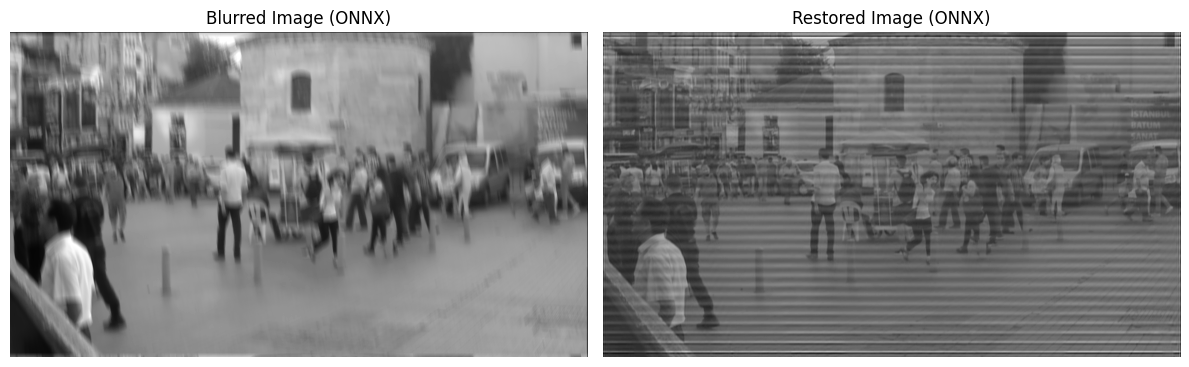

In [123]:
import onnx
import onnx.helper as helper
import onnx.numpy_helper as numpy_helper
import numpy as np
import onnxruntime as ort
from skimage import restoration, io, img_as_float
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# Define the function to create the motion blur PSF
def motion_blur_psf(length, angle):
    size = length
    psf = np.zeros((size, size))
    center = size // 2
    slope = np.tan(np.deg2rad(angle))
    for i in range(size):
        offset = int(center + (i - center) * slope)
        if 0 <= offset < size:
            psf[i, offset] = 1
    psf /= psf.sum()
    return psf

# Create a simple ONNX model for convolution (blurring)
def create_convolution_onnx_model():
    # Create an ONNX graph with input and output tensors
    input_tensor = helper.make_tensor_value_info('input', onnx.TensorProto.FLOAT, [1, 1, None, None])
    psf_tensor = helper.make_tensor_value_info('psf', onnx.TensorProto.FLOAT, [1, 1, 5, 5])
    output_tensor = helper.make_tensor_value_info('output', onnx.TensorProto.FLOAT, [1, 1, None, None])

    # Define the convolution node
    conv_node = helper.make_node(
        'Conv',
        inputs=['input', 'psf'],
        outputs=['output'],
        kernel_shape=[5, 5],
        pads=[2, 2, 2, 2],
    )

    # Create the graph and model
    graph_def = helper.make_graph(
        [conv_node],
        'ConvolutionGraph',
        [input_tensor, psf_tensor],
        [output_tensor]
    )
    model_def = helper.make_model(graph_def, producer_name='convolution_model')

    # Save the model to an ONNX file
    onnx_model_path = 'convolution_model.onnx'
    onnx.save_model(model_def, onnx_model_path)
    return onnx_model_path

# Save the ONNX model
onnx_model_path = create_convolution_onnx_model()

# Load the ONNX model using ONNX Runtime
session = ort.InferenceSession(onnx_model_path)

# Load the original image and preprocess
original_image = io.imread('/kaggle/input/gopro-large/GOPRO_Large/test/GOPR0384_11_00/sharp/000001.png', as_gray=True)
original_image = img_as_float(original_image)
psf = motion_blur_psf(21, 11)
psf_resized = np.resize(psf, (5, 5)).astype(np.float32)  # Adjust PSF size for the ONNX model

# Add Gaussian noise to the blurred image
blurred_noisy_image = convolve(original_image, psf, mode='wrap')
blurred_noisy_image = np.expand_dims(np.expand_dims(blurred_noisy_image, axis=0), axis=0).astype(np.float32)

# Prepare example input data for the ONNX model (reshaped to match expected input)
input_data = blurred_noisy_image
psf_data = np.expand_dims(np.expand_dims(psf_resized, axis=0), axis=0)

# Run inference
inputs = {session.get_inputs()[0].name: input_data, session.get_inputs()[1].name: psf_data}
blurred_image_onnx = session.run(None, inputs)[0]

# Reshape the output to the original image shape
blurred_image_onnx = blurred_image_onnx.reshape(original_image.shape)

# Apply Wiener deconvolution manually
restored_image_onnx = restoration.wiener(blurred_image_onnx, psf, balance=0.01)

# Display the blurred image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(blurred_image_onnx, cmap='gray')
plt.title('Blurred Image (ONNX)')
plt.axis('off')

# Display the restored image
plt.subplot(1, 2, 2)
plt.imshow(restored_image_onnx, cmap='gray')
plt.title('Restored Image (ONNX)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Serving the Models

### Inspecting ONNX Model Outputs (Prints the ouput tensor)

In [124]:
# Load the ONNX model to inspect the output tensor names
model = onnx.load(onnx_model_path)

# Get the names of the output tensors
output_tensor_names = [output.name for output in model.graph.output]

# Print the output tensor names
print("Output tensor names:", output_tensor_names)

Output tensor names: ['output']


## Creating a Flask Application for Image Restoration

1. creates  a flask web apploication to handle image restoration requests
2. A route/'predict' is defined to handle post request containing an image file.

### Creating the Flask APP('app.py')

In [70]:
from flask import Flask, request, send_file
import cv2
import numpy as np
import onnxruntime as ort
from skimage import restoration
from io import BytesIO

app = Flask(__name__)

# Load the ONNX model using ONNX Runtime
onnx_model_path = 'convolution_model.onnx'
session = ort.InferenceSession(onnx_model_path)

# Define the function to create the motion blur PSF

# Define function to preprocess input data
def preprocess_input(image):
    # Preprocess the image as needed (e.g., convert to float, resize, normalize)
    image_float = image.astype(np.float32)
    return np.expand_dims(np.expand_dims(image_float, axis=0), axis=0)

# Define route for prediction
@app.route('/predict', methods=['POST'])
def predict():
    # Get input image from request
    file = request.files['file']
    image = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

    # Preprocess input image
    input_data = preprocess_input(image)

    # Prepare the PSF data
    psf = motion_blur_psf(21, 11)
    psf_resized = np.resize(psf, (5, 5)).astype(np.float32)  # Adjust PSF size for the ONNX model
    psf_data = np.expand_dims(np.expand_dims(psf_resized, axis=0), axis=0)

    # Run inference
    inputs = {session.get_inputs()[0].name: input_data, session.get_inputs()[1].name: psf_data}
    blurred_image_onnx = session.run(None, inputs)[0]

    # Reshape the output to the original image shape
    blurred_image_onnx = blurred_image_onnx.reshape(image.shape)

    # Apply Wiener deconvolution manually
    restored_image_onnx = restoration.wiener(blurred_image_onnx, psf, balance=0.01)

    # Convert restored image to bytes
    restored_image_uint8 = (restored_image_onnx * 255).astype(np.uint8)
    _, restored_image_bytes = cv2.imencode('.png', restored_image_uint8)
    
    # Convert to BytesIO for send_file
    restored_image_io = BytesIO(restored_image_bytes)

    # Send restored image as response
    return send_file(restored_image_io, mimetype='image/png', as_attachment=False, attachment_filename='restored_image.png')

if __name__ == '__main__':
    app.run(port=5010)  # Use a different port, like 5010

 * Serving Flask app '__main__'
 * Debug mode: off


## Run the Flask App in the Notebook

In [71]:
import os

# Save the Flask app code to app.py
with open('app.py', 'w') as f:
    f.write("""
from flask import Flask, request, send_file
import cv2
import numpy as np
import onnxruntime as ort
from skimage import restoration
from io import BytesIO

app = Flask(__name__)

# Load the ONNX model using ONNX Runtime
onnx_model_path = 'convolution_model.onnx'
session = ort.InferenceSession(onnx_model_path)

# Define the function to create the motion blur PSF
def motion_blur_psf(length, angle):
    size = length
    psf = np.zeros((size, size))
    center = size // 2
    slope = np.tan(np.deg2rad(angle))
    for i in range(size):
        offset = int(center + (i - center) * slope)
        if 0 <= offset < size:
            psf[i, offset] = 1
    psf /= psf.sum()
    return psf

# Define function to preprocess input data
def preprocess_input(image):
    # Preprocess the image as needed (e.g., convert to float, resize, normalize)
    image_float = image.astype(np.float32)
    return np.expand_dims(np.expand_dims(image_float, axis=0), axis=0)

# Define route for prediction
@app.route('/predict', methods=['POST'])
def predict():
    # Get input image from request
    file = request.files['file']
    image = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

    # Preprocess input image
    input_data = preprocess_input(image)

    # Prepare the PSF data
    psf = motion_blur_psf(21, 11)
    psf_resized = np.resize(psf, (5, 5)).astype(np.float32)  # Adjust PSF size for the ONNX model
    psf_data = np.expand_dims(np.expand_dims(psf_resized, axis=0), axis=0)

    # Run inference
    inputs = {session.get_inputs()[0].name: input_data, session.get_inputs()[1].name: psf_data}
    blurred_image_onnx = session.run(None, inputs)[0]

    # Reshape the output to the original image shape
    blurred_image_onnx = blurred_image_onnx.reshape(image.shape)

    # Apply Wiener deconvolution manually
    restored_image_onnx = restoration.wiener(blurred_image_onnx, psf, balance=0.01)

    # Convert restored image to bytes
    restored_image_uint8 = (restored_image_onnx * 255).astype(np.uint8)
    _, restored_image_bytes = cv2.imencode('.png', restored_image_uint8)
    
    # Convert to BytesIO for send_file
    restored_image_io = BytesIO(restored_image_bytes)

    # Send restored image as response
    return send_file(restored_image_io, mimetype='image/png', as_attachment=False, attachment_filename='restored_image.png')

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5010)  # Use a different port, like 5010
    """)

# Set the FLASK_APP environment variable and run the Flask app
os.system('FLASK_APP=app.py flask run --host=0.0.0.0 --port=5010')

 * Serving Flask app 'app.py'
 * Debug mode: off


2

In [64]:
from flask import Flask, request  # import main Flask class and request object
import random

In [65]:
app1 = Flask(__name__)  # create the Flask app

In [66]:
@app1.route('/status', methods=['GET'])
def a_live():
    return "Alive!"

In [67]:
@app1.route('/predict', methods=['GET'])
def predict():
    demo=random.randint(2000, 5000)    
    return str(demo)

In [68]:
app1.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off
